In [1]:
%load_ext autoreload
%autoreload 2

# Import Modules

In [2]:
import os
import pickle
import random
import string
import pandas as pd
import numpy as np

from protosearch.ml_modelling.fingerprint import (
    FingerPrint,
    VoronoiFingerprint
    )

pd.set_option("display.max_columns", None)

# Script Inputs

# Read Data

In [3]:
file_i = os.path.join(
    os.environ["PROJ_irox"],
    "workflow/ml_modelling/00_ml_workflow/outdata",
    "01_irox_data_featurized.pickle")
with open(file_i, "rb") as fle:
    df_m = pickle.load(fle)

# Pre-process Data

In [4]:
df_m = df_m[df_m["default_columns"]["stoich"] == "AB3"]

#TEMP
# df_m = df_m[0:20]

# Setting unique ID for each row
def random_id():
    out_id = ''.join(
        random.choices(
            string.ascii_uppercase + string.digits,
            k=10
            )
        )
    return(out_id)

rand_ids = [random_id() for i in range(len(df_m))]
df_m = df_m.set_index(
    np.array(rand_ids),
    drop=False,
    append=False,
    inplace=False,
    verify_integrity=True,
    )

# df_m = df_m[df_m["default_columns"]["formation_e"].notnull()]

df_train = df_m[df_m["default_columns"]["formation_e"].notnull()]
df_test = df_m[df_m["default_columns"]["formation_e"].isnull()]

In [5]:
FP = FingerPrint(**{
    "feature_methods": ["voronoi"],
    "input_data": df_m,
    "input_index": ["default_columns", "atoms"],
    })


FP.generate_fingerprints()
FP.clean_features()
FP.join_input_to_fingerprints()

Generate Voronoi fingerprint of 271 structures


/home/raul_surface/anaconda2/envs/test_bare/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [6]:
df_i = FP.fingerprints

df_train = df_i[df_i["default_columns"]["formation_e"].notnull()]
df_test = df_i[df_i["default_columns"]["formation_e"].isnull()]

y = df_train["default_columns"]["formation_e"].tolist()
X = df_train["voronoi"]  # .values

In [7]:
from sklearn import linear_model
from sklearn.linear_model import Ridge

reg = linear_model.Ridge(alpha=.5)
reg.fit(X, y)
reg.coef_
reg.intercept_ 

y_pred = reg.predict(df_i["voronoi"])
df_i["y_pred"] = y_pred
df_i = df_i.sort_values(by=["y_pred"], axis=0)

df_i["ind"] = [i for i in range(len(df_i))]

In [8]:
import os
import sys

sys.path.insert(0, os.path.join(
    os.environ["PROJ_irox"],
    "workflow/ml_modelling/ml_convergence_plots",
    ))

from methods import process_data_for_plot, get_layout

data_i = process_data_for_plot(
    df_i,
#     color0='red',
#     color1='black',
#     name='temp_name',
#     marker_color_mode='single',
    energy_key='y_pred',
    marker_color_key='color_order',
    uncertainty_key='uncert_0',
    text_key='id',
    process_text_for_hover=False,
    explicit_error_bars=False,
    filled_error_traces=False,
    )

layout_i = get_layout()

import plotly.graph_objs as go
import plotly.plotly as py

save_dir = "__temp__"

fig = dict(data=data_i, layout=layout_i)
py.iplot(
    fig,
    filename=os.path.join(save_dir, "190603_lin_regress_iro3"))

/home/raul_surface/anaconda2/envs/test_bare/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



0 features with greater than 0.20 missing values.

64 features with a correlation magnitude greater than 0.97.



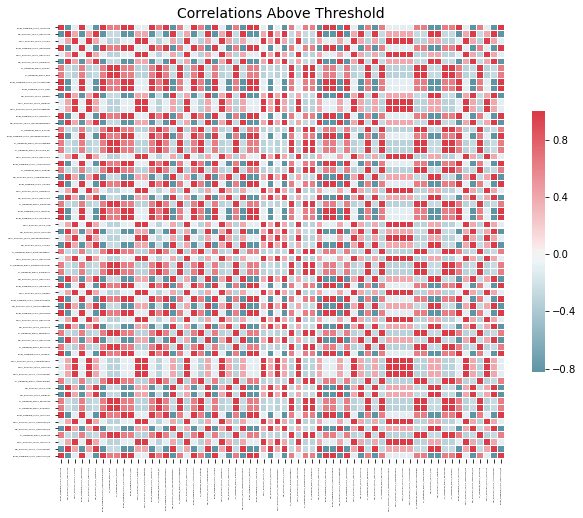

In [26]:
import lightgbm
from feature_selector import FeatureSelector

fs = FeatureSelector(
    data=df_train["voronoi"],
    labels=list(df_train["voronoi"]),
    )

fs.identify_missing(missing_threshold=0.2)

fs.identify_collinear(correlation_threshold=0.975)

fs.plot_collinear(plot_all=False)

In [25]:
fs.identify_zero_importance(task='regression', eval_metric='auc', n_iterations=10, early_stopping=True)

fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

Training Gradient Boosting Model



ValueError: Found input variables with inconsistent numbers of samples: [42, 84]

# Gaussian Process ML Regression

In [10]:
# # Define initial prediction parameters.
# # noise = 0.0042  # Regularisation parameter.

# # sigma_l = 2.3917  # Length scale parameter.
# # sigma_f = 0.5120  # Scaling parameter.
# # alpha = 0.8907  # Alpha parameter.

# noise = 0.0042  # Regularisation parameter.
# sigma_l = 6.3917  # Length scale parameter.
# sigma_f = 0.5120  # Scaling parameter.
# alpha = 0.3907  # Alpha parameter.


# kdict = [
#     {
#         'type': 'quadratic',
#         'dimension': 'single',
#         # 'dimension': 'features',
#         'slope': sigma_l,
#         'scaling': sigma_f,
#         'degree': alpha,
#         }
#     ]

# gp = GaussianProcess(
#     kernel_list=kdict, regularization=noise, train_fp=train_x,
#     train_target=train_y, optimize_hyperparameters=False,
#     scale_data=False)

# print('Optimized kernel:', gp.kernel_list)

# # Optimize hyperparameters:
# gp.optimize_hyperparameters(global_opt=True)

In [11]:
# tmp = pd.merge(df_m, FP.fingerprints,
#     left_index=True,
#     right_index=True,
#     indicator=True,
#     )

# FP = FingerPrint(**{
#     "feature_methods": ["voronoi"],
#     "input_objects": atoms_list,
#     })

# FP.generate_fingerprints()

# FP.clean_features()

# from catlearn.preprocess.scaling import (
#     standardize,
#     normalize,
#     min_max,
#     unit_length,
#     target_standardize,
#     target_normalize,
#     target_center,
#     )

# std_data = standardize(
#     FP.fingerprints.values,
#     test_matrix=None,
#     mean=None,
#     std=None,
#     local=True,
#     )

# std_data.keys()
# # pd.DataFrame(std_data["train"])

# df_tmp = pd.DataFrame(
#     data=output["train"],
#     # columns=output["labels"],
#     )

# multi_index = pd.MultiIndex.from_tuples(
#     [tuple(i) for i in output["labels"]],
#     # names=("tmp1", "tmp2"),
#     )

# df_tmp.columns = multi_index
# df_tmp

# output["train"].shape

# output["labels"]

# # output["labels"]

# multiindex_i = FP.fingerprints.columns

# # dir(multiindex_i)

# # pd.MultiIndex.from_arrays(output["labels"], names=("tmp1", "tmp2"))

# pd.MultiIndex.from_tuples([tuple(i) for i in output["labels"]], names=("tmp1", "tmp2"))

# df_features = FP.fingerprints



# from ase import Atoms



# isinstance(
#     FP.__feature_instances__["voronoi"].atoms_list[0],
#     Atoms,
#     )

# import pandas as pd

# df0 = pd.DataFrame([
#     {"a": 1, "b": 2},
#     {"a": 3, "b": 4},
#     ]
#     )

# df1 = pd.DataFrame([
#     {"x": 1, "y": 2},
#     {"x": 3, "y": 4},
#     ]
#     )





# columns_to_remove = []
# for column in df_features:
#     tmp = 42
#     num_unique_vals = len(list(set(df_features[column].tolist())))

#     if num_unique_vals == 1:
#         columns_to_remove.append(column)

# df_tmp = df_features.drop(columns_to_remove, axis=1)





# print(df_features.shape)

# import copy
# from catlearn.preprocess.clean_data import (
#     clean_infinite,
#     clean_variance,
#     clean_infinite,
#     clean_skewness,
#     )

# df_features_cpy = copy.deepcopy(df_features)

# train_features = df_features_cpy.values
# train_labels = list(df_features_cpy)

# output = clean_variance(
#     train_features,
#     test=None,
#     # labels=train_labels,
#     mask=None,
#     )
# train_features = output["train"]
# print(train_features.shape)

# output = clean_infinite(
#     train_features,
#     test=None,
#     targets=None,
#     labels=None,
#     mask=None,
#     max_impute_fraction=0,
#     strategy='mean',
#     )
# train_features = output["train"]
# print(train_features.shape)

# output = clean_skewness(
#     train_features,
#     test=None,
#     labels=None,
#     mask=None,
#     skewness=3.,
#     )
# train_features = output["train"]
# print(train_features.shape)